<a href="https://colab.research.google.com/github/fabianoacastro/ProjetoFinal/blob/main/Analise_ENEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Geral

Se estiver executando este exercício no Google Colab, execute as próximas duas células. 

Caso esteja executando localmente, não é necessário executar mas certifique-se de que o **pyspark** está instalado e configurado em sua máquina.

In [ ]:
%%bash

# Instal Java
apt-get update && apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install PySpark
pip install -q pyspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 261 kB in 3s (99.3 kB/s)
Reading package li

In [ ]:
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
# Setup Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("AtividadeSQL").getOrCreate()

##Ponto de Montagem Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Leitura de diretorio razi

In [ ]:
%%bash

ls /content

Dicionário_Microdados_Enem_2020.xlsx
drive
group_enem.csv
MICRODADOS_ENEM_2020.csv
sample_data


##Descompactar arquivo ZIP com dados ENEM

In [ ]:
from zipfile import ZipFile

z = ZipFile('/content/drive/MyDrive/DADOS/MICRODADOS_ENEM_2020.zip', 'r')
z.extractall()

##Carregar Dataframe df com dado ENEM

In [ ]:
from pyspark.sql.functions import col

path = '/content/MICRODADOS_ENEM_2020.csv'
df = spark.read.options(header="True",inferSchema='True',delimiter=';') \
          .csv(path)
df = df.select("TP_FAIXA_ETARIA","TP_SEXO","TP_ESTADO_CIVIL","TP_COR_RACA","IN_TREINEIRO")
df = df.withColumn("IN_TREINEIRO",col("IN_TREINEIRO").cast("String"))


In [ ]:
df.show(5)

+---------------+-------+---------------+-----------+------------+
|TP_FAIXA_ETARIA|TP_SEXO|TP_ESTADO_CIVIL|TP_COR_RACA|IN_TREINEIRO|
+---------------+-------+---------------+-----------+------------+
|             11|      F|              1|          2|           0|
|             11|      M|              2|          3|           0|
|              4|      F|              2|          3|           0|
|              2|      M|              1|          3|           0|
|              4|      F|              1|          3|           0|
+---------------+-------+---------------+-----------+------------+
only showing top 5 rows



## Carregar Dicionario Faixa Etária com dados excel utilizando pandas

In [ ]:
import pandas

df_dict = pandas.read_excel('/content/Dicionário_Microdados_Enem_2020.xlsx', sheet_name='MICRODADOS_ENEM_2020', skiprows=6)


In [ ]:
df_dict = df_dict.iloc[:,[2,3]][:20]
df_pd = spark.createDataFrame(df_dict)

In [ ]:
df_pd = df_pd.withColumnRenamed("Unnamed: 2","TP_FAIXA_ETARIA") \
            .withColumnRenamed("Unnamed: 3","FAIXA_ETARIA")
df_pd.show()

+---------------+------------------+
|TP_FAIXA_ETARIA|      FAIXA_ETARIA|
+---------------+------------------+
|              1|  Menor de 17 anos|
|              2|           17 anos|
|              3|           18 anos|
|              4|           19 anos|
|              5|           20 anos|
|              6|           21 anos|
|              7|           22 anos|
|              8|           23 anos|
|              9|           24 anos|
|             10|           25 anos|
|             11|Entre 26 e 30 anos|
|             12|Entre 31 e 35 anos|
|             13|Entre 36 e 40 anos|
|             14|Entre 41 e 45 anos|
|             15|Entre 46 e 50 anos|
|             16|Entre 51 e 55 anos|
|             17|Entre 56 e 60 anos|
|             18|Entre 61 e 65 anos|
|             19|Entre 66 e 70 anos|
|             20|  Maior de 70 anos|
+---------------+------------------+



###Relacionar dados do dicionário de faixa etária com dados ENEM

In [ ]:
df_join = df.join(df_pd,df_pd.TP_FAIXA_ETARIA == df.TP_FAIXA_ETARIA, 'inner')

df_join = df_join.select(df_pd.FAIXA_ETARIA,df.TP_SEXO,df.TP_ESTADO_CIVIL,df.TP_COR_RACA,df.IN_TREINEIRO)

%md
#### Apresentar dados por sexo e faixa etaria

In [ ]:
#df_group = df_join.groupBy(df_pd.FAIXA_ETARIA,df.TP_SEXO).count()
df_group = df_join.groupBy(df_pd.FAIXA_ETARIA).count()
df_group.sort(df_group.FAIXA_ETARIA).show(5)
var_faixa = df_group.select("FAIXA_ETARIA").rdd.flatMap(lambda x: x).collect()
var_num = df_group.select("count").rdd.flatMap(lambda x: x).collect()

+------------+------+
|FAIXA_ETARIA| count|
+------------+------+
|     17 anos|775404|
|     18 anos|887715|
|     19 anos|609450|
|     20 anos|459606|
|     21 anos|353734|
+------------+------+
only showing top 5 rows



In [ ]:
print(var_faixa)
print(var_num)

['20 anos', '21 anos', 'Entre 46 e 50 anos', 'Entre 56 e 60 anos', '24 anos', '25 anos', 'Entre 61 e 65 anos', '22 anos', 'Menor de 17 anos', '18 anos', 'Entre 36 e 40 anos', '23 anos', 'Entre 26 e 30 anos', 'Entre 41 e 45 anos', 'Entre 31 e 35 anos', 'Maior de 70 anos', '19 anos', 'Entre 66 e 70 anos', 'Entre 51 e 55 anos', '17 anos']
[459606, 353734, 86079, 22383, 204689, 177344, 8144, 274709, 336805, 887715, 235027, 239812, 575442, 143795, 341808, 931, 609450, 2693, 47539, 775404]


##### Apresentar Grafico Faixa Etária

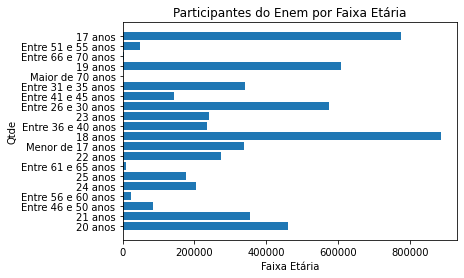

In [ ]:
import matplotlib.pyplot as plt

plt.barh(var_faixa,var_num)

plt.ylabel('Qtde')

plt.xlabel('Faixa Etária')

plt.title('Participantes do Enem por Faixa Etária')

plt.show()

## Carregar Dicionario Raça com dados excel utilizando pandas

In [ ]:
import pandas

df_dictraca = pandas.read_excel('/content/Dicionário_Microdados_Enem_2020.xlsx', sheet_name='MICRODADOS_ENEM_2020', skiprows=33)
df_pdraca = df_dictraca.iloc[:,[2,3]][:6]
df_pdraca = spark.createDataFrame(df_pdraca)

In [ ]:
df_pdraca = df_pdraca.withColumnRenamed("4","TP_COR_RACA") \
            .withColumnRenamed("Viúvo(a)","RACA")
df_pdraca.show()

+-----------+-------------+
|TP_COR_RACA|         RACA|
+-----------+-------------+
|          0|Não declarado|
|          1|       Branca|
|          2|        Preta|
|          3|        Parda|
|          4|      Amarela|
|          5|    Indígena |
+-----------+-------------+



###Relacionar dados do dicionário de Raça com dados ENEM

In [ ]:
df_join = df.join(df_pdraca,df_pdraca.TP_COR_RACA == df.TP_COR_RACA, 'inner')

df_join = df_join.select(df_pdraca.RACA,df.TP_SEXO,df.TP_ESTADO_CIVIL,df.TP_COR_RACA,df.IN_TREINEIRO)

#### Apresentar dados por Raça

##### Carregar Listas

In [ ]:
df_group = df_join.groupBy(df_pdraca.RACA).count()
var_raca = df_group.select("RACA").rdd.flatMap(lambda x: x).collect()
var_num = df_group.select("count").rdd.flatMap(lambda x: x).collect()


In [ ]:
print(var_raca)
print(var_num)

['Não declarado', 'Preta', 'Amarela', 'Branca', 'Indígena ', 'Parda']
[116883, 771740, 128522, 2007633, 37846, 2720485]


##### Apresentar Gráfico Raça

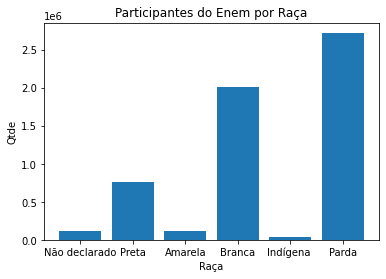

In [ ]:
import matplotlib.pyplot as plt

plt.bar(var_raca,var_num)

plt.ylabel('Qtde')

plt.xlabel('Raça')

plt.title('Participantes do Enem por Raça')

plt.show()